# 4. Spot check algorithms
In order to rapidly test different models, we'll spot check algorithms, as presented by __[Jason Brownlee](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/)__. This will help point towards the best adapted algorithms for this problem. Once we've identified these models, we can fine tune them in order to further improve their performances.
## Libraries to import

In [1]:
# import libraries
import pandas as pd
import numpy as np
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

//anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Functions defintion
Now, we'll define the functions to develop a reusable framework to spot check algorithms.

In [2]:
# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['svr'] = SVR(kernel = 'rbf')
    models['dt'] = DecisionTreeRegressor()
    models['rf'] = RandomForestRegressor()
    return models

We don't normalise the data here.

In [3]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    #steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [4]:
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores

We silence warnings when evaluating models, by building a robust_evaluate_model function.

In [5]:
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores

In [6]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = mean(scores), std(scores)
            print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('>%s: error' % name)
    return results

In [7]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize  
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for metric)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	
    # boxplot for the top n
    pyplot.boxplot(scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    pyplot.savefig('spotcheck.png') 

## Load data and spot check algorithms
Now that all the functions are defined, let's load our data and launch our models and compare them using the mean squared error as scoring metric. 
"Note that by default scikit-learn inverts error scores so that that are maximizing instead of minimizing. This is why the mean squared error is negative and will have a negative sign when summarized. Because the score is inverted, we can continue to assume that we are maximizing scores in the summarize_results() function and do not need to specify maximize=False as we might expect when using an error metric."

In [8]:
# load dataset
path = " " # define path
df = pd.read_excel(path+"Real estate valuation data set.xlsx")
df.info()

df.set_index('No', inplace = True)
    
X = df.drop('Y house price of unit area', axis =1)
y = df['Y house price of unit area'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
No                                        414 non-null int64
X1 transaction date                       414 non-null float64
X2 house age                              414 non-null float64
X3 distance to the nearest MRT station    414 non-null float64
X4 number of convenience stores           414 non-null int64
X5 latitude                               414 non-null float64
X6 longitude                              414 non-null float64
Y house price of unit area                414 non-null float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


>lr: -79.168 (+/-43.890)
>svr: -76.645 (+/-43.158)
>dt: -93.626 (+/-50.008)
>rf: -63.184 (+/-40.344)

Rank=1, Name=rf, Score=-63.184 (+/- 40.344)
Rank=2, Name=svr, Score=-76.645 (+/- 43.158)
Rank=3, Name=lr, Score=-79.168 (+/- 43.890)
Rank=4, Name=dt, Score=-93.626 (+/- 50.008)


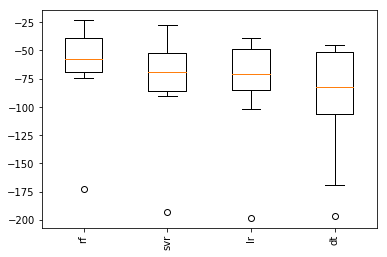

In [9]:
# get model list
models = get_models()

# evaluate models
results = evaluate_models(X, y, models, metric='neg_mean_squared_error')

# summarize results
summarize_results(results)

>lr: 0.582 (+/-0.133)
>svr: 0.597 (+/-0.131)
>dt: 0.467 (+/-0.371)
>rf: 0.668 (+/-0.134)

Rank=1, Name=rf, Score=0.668 (+/- 0.134)
Rank=2, Name=svr, Score=0.597 (+/- 0.131)
Rank=3, Name=lr, Score=0.582 (+/- 0.133)
Rank=4, Name=dt, Score=0.467 (+/- 0.371)


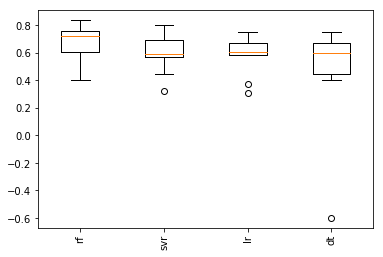

In [10]:
# get model list
models = get_models()

# evaluate models
results = evaluate_models(X, y, models, metric='r2')

# summarize results
summarize_results(results)

The random forest algorithm has the best performance, based on the mean square error and R2 metrics. We'll then try to fine tune this model to further improve its performance.